# A look to egamma manpower

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates

## Import the data

In [3]:
data_list = (('egamma', ('calibration', 'photon_id', 'electron_id', 'tp_software', 'egamma', 'informal_ml')),
             )#('higgs', ('HSG1', 'HSG3')))

df = []
df_meeting = []              
              
for group, subgroups in data_list:
    contributions = pd.concat([pd.read_pickle(s + "_contributions.pkl") for s in subgroups])
    meeting = pd.concat([pd.read_pickle(s + '_meeting.pkl') for s in subgroups])
    joined = contributions.join(meeting, on='id_meeting', lsuffix='_contribution')
    meeting['group'] = group
    joined['group'] = group
    df.append(joined)
    df_meeting.append(meeting)
              
df = pd.concat(df)
df_meeting = pd.concat(df_meeting)  
df = df.reset_index().set_index(['id_meeting', 'id_contribution'])
              
df_meeting_grouped_by_mytitle = df_meeting.groupby('my_title')
df_meeting_grouped_by_mytitle_not_null = df_meeting[df_meeting['contributions'] > 0].groupby('my_title')
df_grouped_by_group = df.groupby('group')

In [4]:
df.head()

duration  \
id_meeting id_contribution             
791539     1                      20   
           2                      20   
           3                      20   
           4                      20   
           5                      20   

                                                           title_contribution  \
id_meeting id_contribution                                                      
791539     1                                                     Introduction   
           2                LAr temperatures and induced effects on ECAL r...   
           3                                                Forward electrons   
           4                                          pT1 pT2 correlation (?)   
           5                pedestal shift for low mu calibration extrapol...   

                                    speaker  contributions  \
id_meeting id_contribution                                   
791539     1                Fanti, Marcello              5   
           2                Unal, Guillaume              5   
           3                     Wang, Chen              5   
           4                 Delgove, David              5   
           5                Unal, Guillaume              5   

                                         title date_meeting     my_title  \
id_meeting id_contribution                                                 
791539     1                EGamma Calibration   2019-01-24  calibration   
           2                EGamma Calibration   2019-01-24  calibration   
           3                EGamma Calibration   2019-01-24  calibration   
           4                EGamma Calibration   2019-01-24  calibration   
           5                EGamma Calibration   2019-01-24  calibration   

                             group  
id_meeting id_contribution          
791539     1                egamma  
           2                egamma  
           3                egamma  
           4                egamma  
           5                egamma

## Full period

In [5]:
df_fullrange = df.copy()
df = df[df['date_meeting'] < datetime.datetime(2022, 1, 1)]
df_meeting = df_meeting[df_meeting['date_meeting'] < datetime.datetime(2022, 1, 1)]

time_range_string = "{} - {}".format(df['date_meeting'].min().strftime("%m/%Y"), df['date_meeting'].max().strftime("%m/%Y"))
print("Time range: {}, {}".format(df['date_meeting'].min(), df['date_meeting'].max()))

Time range: 2014-01-07 00:00:00, 2021-12-16 00:00:00


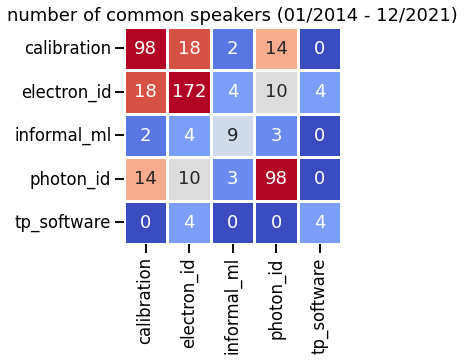

In [6]:
d = df.groupby(['speaker', 'my_title']).size().unstack(fill_value=0) != 0
d = d.drop('egamma', axis='columns')
result = {}
for group1 in d.columns:
    for group2 in d.columns:
        n_common = (d[group1] & d[group2]).sum()
        result[(group1, group2)] = n_common

sns.set_context('talk')

fig, ax = plt.subplots()
result = pd.Series(result).unstack(fill_value=0)

sns.heatmap(result,cmap='coolwarm', vmax=20, linewidths=3, square=True, annot=True, cbar=False, fmt='.0f')
ax.set_title('number of common speakers (%s)' % time_range_string)
fig.savefig('common_speaker.pdf', bbox_inches='tight')

## Total number of contributions

In [7]:
total_count = df_meeting.groupby('my_title')['contributions'].sum()
pd.DataFrame(total_count)

,contributions
my_title,
calibration,951
egamma,1466
electron_id,1297
informal_ml,18
photon_id,760
tp_software,9


In [8]:
d = df_meeting.groupby(['my_title', df_meeting['date_meeting'].dt.year])['contributions'].sum().unstack(fill_value=0)
d.loc['total', :] = d.sum()
d = d.astype(int)
open('contributions.tex', 'w').write(d.to_latex())
d

date_meeting,2014,2015,2016,2017,2018,2019,2020,2021
my_title,,,,,,,,
calibration,26,131,92,203,128,108,136,127
egamma,251,249,181,193,192,172,118,110
electron_id,130,291,227,163,142,102,131,111
informal_ml,0,0,0,0,0,0,11,7
photon_id,7,80,114,143,138,107,81,90
tp_software,0,0,0,0,0,0,0,9
total,414,751,614,702,600,489,477,454


### Normalized to egamma plenary

In [9]:
pd.DataFrame(total_count / total_count['egamma'])

,contributions
my_title,
calibration,0.648704
egamma,1.000000
electron_id,0.884720
informal_ml,0.012278
photon_id,0.518417
tp_software,0.006139


## Number of contributions per months
Number of contributions, as in the indico meeting page, grouped by months

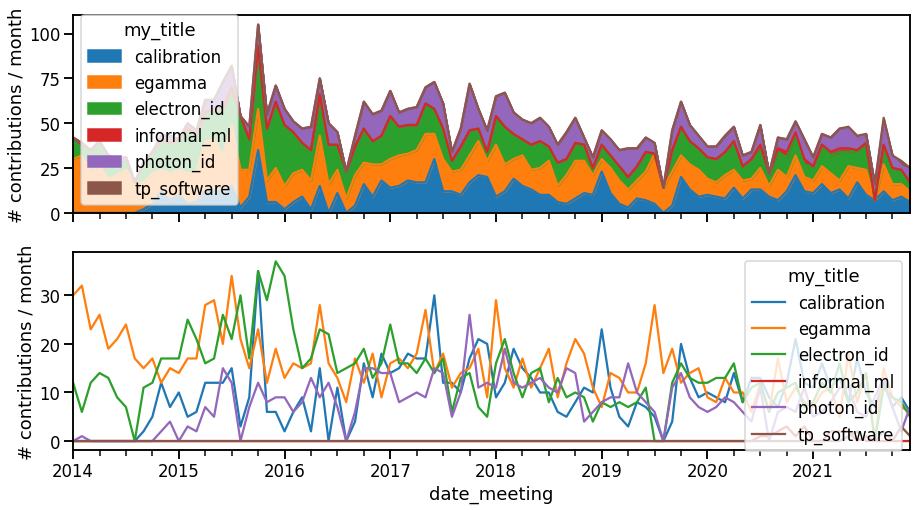

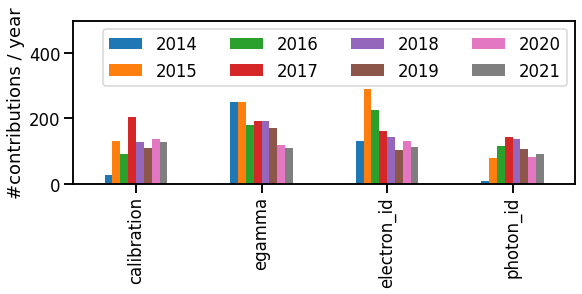

In [10]:
f, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
df_meeting.groupby([pd.Grouper(freq='MS',key='date_meeting'), 'my_title'])['contributions'].sum().unstack().fillna(0).plot(kind='area', ax=axs[0])
df_meeting.groupby([pd.Grouper(freq='MS',key='date_meeting'), 'my_title'])['contributions'].sum().unstack().fillna(0).plot(ax=axs[1])

for ax in axs: ax.set_ylabel('# contributions / month')
fig, ax = plt.subplots(figsize=(9, 3))

df_meeting.groupby(['my_title', df_meeting['date_meeting'].dt.year])['contributions'].sum().unstack(fill_value=0).drop(['informal_ml', 'tp_software']).plot(kind='bar', ax=ax)
ax.set_ylim(None, 500)
ax.legend(loc=0, ncol=4)
ax.set_ylabel('#contributions / year')
ax.set_xlabel('')
fig.savefig('contributions_year.pdf', bbox_inches='tight')
plt.show()

## Number of minutes
Sum of the duration of each contribution, grouped per months

In [11]:
total_minutes = df.groupby(('my_title'))['duration'].sum()
pd.DataFrame(total_minutes)

,duration
my_title,
calibration,17760
egamma,24481
electron_id,23290
informal_ml,360
photon_id,13075
tp_software,180


In [12]:
d = df.groupby(['my_title', df['date_meeting'].dt.year])['duration'].sum().unstack(fill_value=0)
d.loc['total', :] = d.sum(axis=0)
d = d.astype(int)
open('minutes.tex', 'w').write(d.to_latex())
d

date_meeting,2014,2015,2016,2017,2018,2019,2020,2021
my_title,,,,,,,,
calibration,445,2370,1570,3800,2380,2335,2430,2430
egamma,4095,3901,3155,3095,3310,2955,2070,1900
electron_id,2545,5180,3885,2915,2395,1860,2540,1970
informal_ml,0,0,0,0,0,0,220,140
photon_id,110,1510,2095,2765,2370,1765,1165,1295
tp_software,0,0,0,0,0,0,0,180
total,7195,12961,10705,12575,10455,8915,8425,7915


### Subgroup fractions

In [13]:
total_minutes_not_plenary = total_minutes[total_minutes.index != 'egamma']
pd.DataFrame(total_minutes_not_plenary / total_minutes_not_plenary.sum())

,duration
my_title,
calibration,0.324888
electron_id,0.426050
informal_ml,0.006586
photon_id,0.239184
tp_software,0.003293


In [14]:
df_no_plenary = df[df['my_title'] != 'egamma']
d1 = pd.DataFrame(df_no_plenary.groupby(['my_title', df_no_plenary['date_meeting'].dt.year])['duration'].sum())
d1.index.names = ['my_title', 'year']

d2 = pd.DataFrame(df_no_plenary.groupby([df_no_plenary['date_meeting'].dt.year])['duration'].sum())
d2.index.names = ['year']

(d1 / d2).unstack()

duration                                                    \
year             2014      2015      2016      2017      2018      2019   
my_title                                                                  
calibration  0.143548  0.261589  0.207947  0.400844  0.333100  0.391779   
electron_id  0.820968  0.571744  0.514570  0.307489  0.335199  0.312081   
informal_ml       NaN       NaN       NaN       NaN       NaN       NaN   
photon_id    0.035484  0.166667  0.277483  0.291667  0.331700  0.296141   
tp_software       NaN       NaN       NaN       NaN       NaN       NaN   

                                 
year             2020      2021  
my_title                         
calibration  0.382376  0.403990  
electron_id  0.399685  0.327515  
informal_ml  0.034618  0.023275  
photon_id    0.183320  0.215295  
tp_software       NaN  0.029925

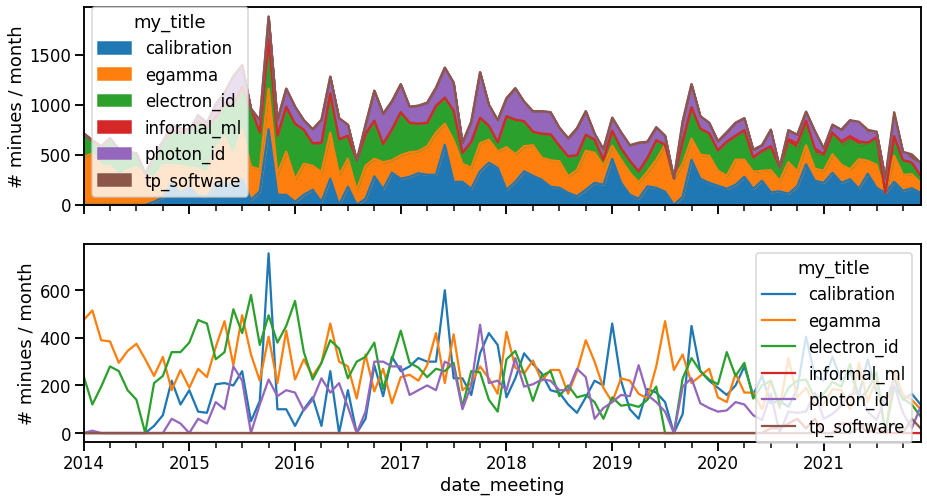

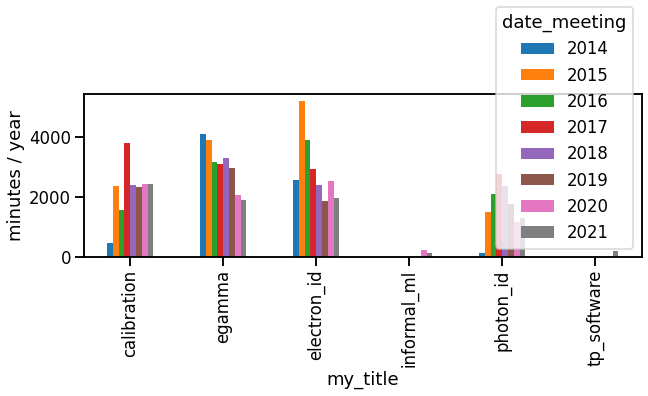

In [15]:
f, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
gr = df.groupby([pd.Grouper(freq='MS',key='date_meeting'), 'my_title'])['duration'].sum().unstack().fillna(0)
gr.plot(kind='area', ax=axs[0])
gr.plot(ax=axs[1])
for ax in axs: ax.set_ylabel('# minues / month')
    
f, ax = plt.subplots(figsize=(10, 3))
df.groupby(['my_title', df['date_meeting'].dt.year])['duration'].sum().unstack().fillna(0).plot(kind='bar', ax=ax)

ax.set_ylabel('minutes / year')
plt.show()    

## Number of contributions per meeting
Including introductions. Do not count meetings with 0 contributions.

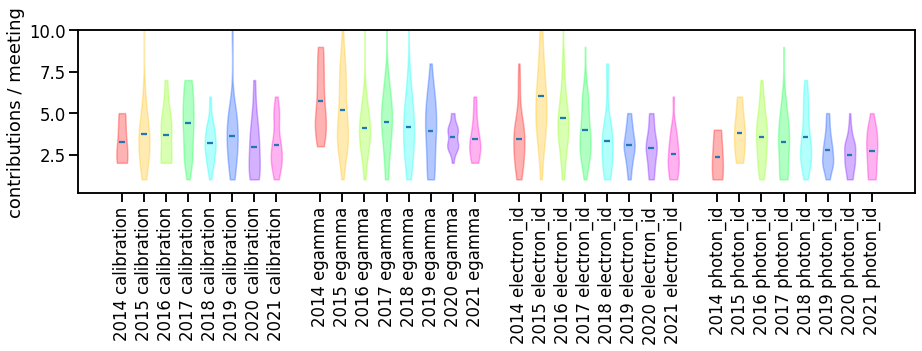

In [16]:
fig, ax = plt.subplots(figsize=(15, 3))

gr = df_meeting[(df_meeting['contributions'] > 0) & (df_meeting['my_title'] != 'informal_ml') & (df_meeting['my_title'] != 'tp_software')]
gr = gr.groupby([df_meeting['date_meeting'].dt.year, 'my_title'])['contributions']
keys = [k for k, v in gr]
title_keys = list(np.unique([k[0] for k in keys]))
years_keys = list(np.unique([k[1] for k in keys]))
pos = [years_keys.index(k[1]) * (len(title_keys) + 1) + title_keys.index(k[0]) for k in keys]
violins = ax.violinplot([v.values for k, v in gr], showextrema=False, showmeans=True, positions=pos)
for k, body in zip(keys, violins['bodies']):
    body.set_color(cm.hsv(title_keys.index(k[0]) / float(len(title_keys))))
ax.set_xticks(pos)
ax.set_ylim(None, 10)
ax.set_xticklabels([' '.join(map(str, k)) for k in keys], rotation='vertical')
ax.set_ylabel('contributions / meeting')
gr.aggregate(['mean', 'std']).unstack()
fig.savefig('contributions_per_meeting.pdf', bbox_inches='tight')

## Meeting duration
Including introductions. Do not count meetings with 0 contributions.

<ipython-input-17-a576ce120648>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gr = df.groupby(['my_title', 'id_meeting', df['date_meeting'].dt.year])["duration", 'my_title'].sum()


id_meeting                                              \
                       mean                                               
my_title        calibration         egamma    electron_id   informal_ml   
date_meeting                                                              
2014           4.261629e+46  6.616870e+261  7.655324e+225           NaN   
2015          1.039690e+208  7.585695e+285  7.504903e+285           NaN   
2016          1.927498e+148  1.078353e+262  9.936198e+285           NaN   
2017          1.300453e+274  1.301964e+256  1.460055e+244           NaN   
2018          1.726707e+238  1.500717e+274  1.609595e+256           NaN   
2019          2.611209e+178  1.781411e+262  2.390927e+196           NaN   
2020          1.909971e+274  2.659781e+196  1.914462e+268  1.171392e+47   
2021          2.442573e+282  3.125550e+220  2.326539e+295  2.028114e+33   

                                                                       \
                                                    std                 
my_title          photon_id   tp_software   calibration        egamma   
date_meeting                                                            
2014           1.012078e+17           NaN   5978.934818  19116.862232   
2015          1.766692e+124           NaN  33735.980250  33997.218584   
2016          1.490686e+190           NaN  35592.505927  27630.198498   
2017          1.366992e+262           NaN  25228.275906  53713.424895   
2018          1.775463e+232           NaN  27132.247913  26573.945688   
2019          2.015830e+232           NaN  28286.243665  24324.877108   
2020          2.663988e+196           NaN  32889.450033  33294.503213   
2021          3.041552e+226  1.155752e+61  32245.035751  32076.129136   

                                          ...    duration              \
                                          ...        mean               
my_title       electron_id   informal_ml  ... electron_id informal_ml   
date_meeting                              ...                           
2014          20117.356552           NaN  ...   66.973684         NaN   
2015          35623.072068           NaN  ...  107.916667         NaN   
2016          28080.914764           NaN  ...   80.937500         NaN   
2017          25143.625116           NaN  ...   71.097561         NaN   
2018          25201.507859           NaN  ...   55.697674         NaN   
2019          25018.188896           NaN  ...   56.363636         NaN   
2020          24095.381974  17751.227966  ...   56.444444        27.5   
2021          40541.898659  11808.773073  ...   44.772727        28.0   

                                                                        \
                                            std                          
my_title      photon_id tp_software calibration     egamma electron_id   
date_meeting                                                             
2014          36.666667         NaN   27.958835  33.501404   33.882537   
2015          71.904762         NaN   71.004793  43.813793   35.532924   
2016          65.468750         NaN   30.723227  34.589674   39.875554   
2017          62.840909         NaN   36.495649  34.643414   30.485902   
2018          60.769231         NaN   22.949219  37.423674   35.549787   
2019          45.256410         NaN   39.993175  38.145952   25.349825   
2020          35.303030         NaN   33.294180  17.051893   29.049766   
2021          39.242424        20.0   29.549978  22.279384   26.978772   

                                                 
                                                 
my_title     informal_ml  photon_id tp_software  
date_meeting                                     
2014                 NaN  25.166115         NaN  
2015                 NaN  25.810666         NaN  
2016                 NaN  32.635805         NaN  
2017                 NaN  32.410839         NaN  
2018                 NaN  29.923993         NaN  
2019                 Na

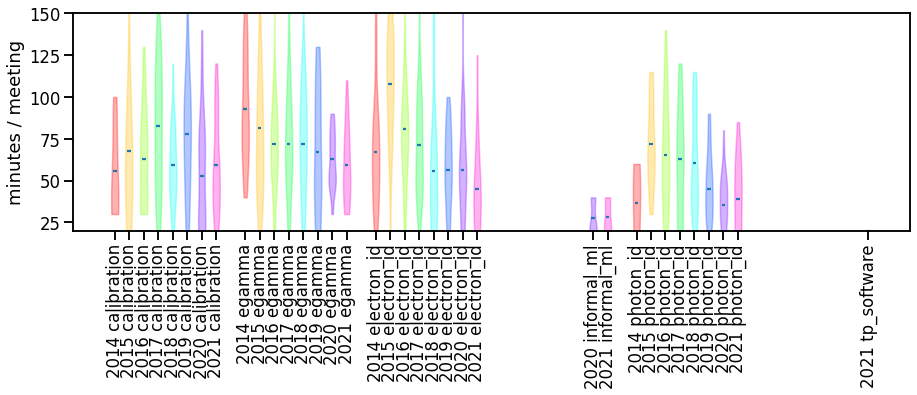

In [17]:
f, ax = plt.subplots(figsize=(15, 4), sharey=True)



gr = df.groupby(['my_title', 'id_meeting', df['date_meeting'].dt.year])["duration", 'my_title'].sum()
gr = gr.reset_index().groupby(['date_meeting', 'my_title'])
keys = [k for k, v in gr]
title_keys = list(np.unique([k[0] for k in keys]))
years_keys = list(np.unique([k[1] for k in keys]))
pos = [years_keys.index(k[1]) * (len(title_keys) + 1) + title_keys.index(k[0]) for k in keys]
violins = ax.violinplot([v['duration'].values for k, v in gr], showextrema=False, showmeans=True, positions=pos)

for k, body in zip(keys, violins['bodies']):
    body.set_color(cm.hsv(title_keys.index(k[0]) / float(len(title_keys))))
ax.set_xticks(pos)
ax.set_xticklabels([' '.join(map(str, k)) for k in keys], rotation='vertical')
ax.set_ylabel('minutes / meeting')
ax.set_ylim(20, 150)

gr.aggregate(['mean', 'std']).unstack()

Text(0, 0.5, 'minutes / meeting')

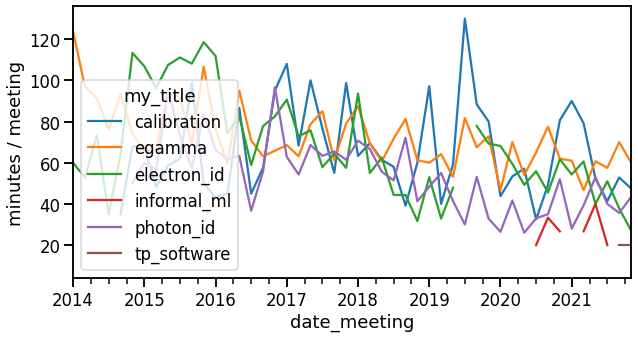

In [18]:
s =df.groupby(['date_meeting', 'my_title'])["duration"].sum().unstack()
s['date_meeting'] = s.index
ax = s.groupby(pd.Grouper(freq='2MS',key='date_meeting')).mean().plot(figsize=(10, 5))
ax.set_ylabel('minutes / meeting')

AttributeError: 'AxesSubplot' object has no attribute 'flat'

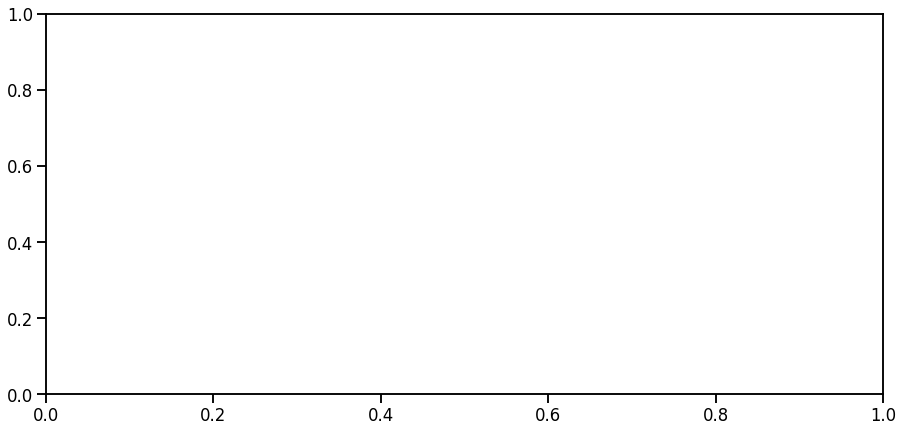

In [19]:
f, axs = plt.subplots(len(df_grouped_by_group), 1, figsize=(15, 7))
for ax, (group, df_group) in zip(axs.flat, df_grouped_by_group):
    df_group.groupby([pd.Grouper(freq='1MS',key='date_meeting'), 'my_title'])['duration'].sum().unstack().fillna(0).plot(kind='area', ax=ax)
    ax.set_ylabel('minutes / month')
    ax.set_xlabel('date meeting')
    ax.set_title(group)

min_x = np.min([ax.get_xlim()[0] for ax in axs.flat])
max_x = np.max([ax.get_xlim()[1] for ax in axs.flat])

for ax in axs.flat:
    print(ax.get_xlim())
    #ax.set_xlim(min_x, max_x)

plt.tight_layout()
plt.show()    

## Total number of people who made a talk
Only 1 person is counted for each talk (the first). Introduction (matching "Introduction" case insensitive) talk are not considered.

In [113]:
mask_introduction = df.apply(lambda x: 'introduction' in x['title_contribution'].lower(), axis=1)
no_intro = df[np.logical_not(mask_introduction)]
pd.DataFrame(no_intro.groupby([no_intro['date_meeting'].dt.year])['speaker'].nunique())

,speaker
date_meeting,
2014,119
2015,123
2016,130
2017,116
2018,130
2019,118
2020,116
2021,104


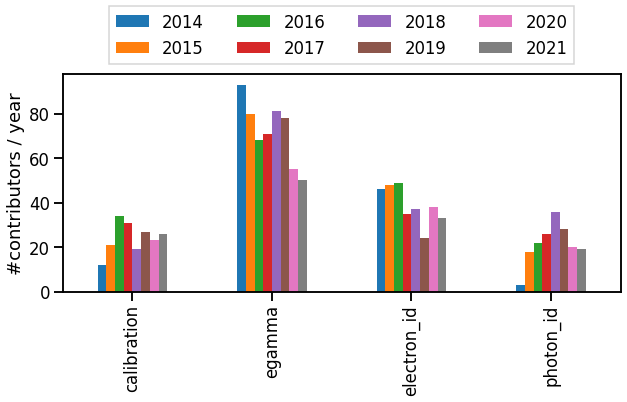

my_title,calibration,egamma,electron_id,informal_ml,photon_id,tp_software
date_meeting,,,,,,
2014,12,93,46,0,3,0
2015,21,80,48,0,18,0
2016,34,68,49,0,22,0
2017,31,71,35,0,26,0
2018,19,81,37,0,36,0
2019,27,78,24,0,28,0
2020,23,55,38,8,20,0
2021,26,50,33,4,19,4


In [162]:
fig, ax = plt.subplots(figsize=(10, 4))
no_intro.groupby([no_intro['date_meeting'].dt.year, 'my_title'])['speaker'].nunique().unstack(fill_value=0).drop(columns=['informal_ml', 'tp_software']).T.plot.bar(ax=ax)
ax.set_ylabel('#contributors / year')
ax.set_xlabel('')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          fancybox=False, shadow=False, ncol=4)
fig.savefig('contributors_year.pdf', bbox_inches='tight')
plt.show()

no_intro.groupby([no_intro['date_meeting'].dt.year, 'my_title'])['speaker'].nunique().unstack(fill_value=0)

## Minutes of talks per person
Only 1 person is counted for each talk (the first). Introduction (matching "Introduction" case insensitive) talk are not considered.

In [ ]:
duration_per_person = pd.DataFrame(no_intro.groupby(['speaker', 'my_title'])['duration', 'my_title'].sum()).unstack()['duration']
duration_per_person.hist(bins=np.linspace(0, 400, 10))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
d = {}
for k, v in no_intro.groupby(['my_title', 'speaker'])['duration'].sum().reset_index().groupby('my_title')['duration']:
    d[k] = v.values
ax.violinplot(d.values(), showmeans=True, showextrema=False, vert=False)
ax.set_yticks(range(1, len(d) + 1))
ax.set_yticklabels(d.keys())
ax.set_xlabel('#minutes / unique person')

## Most common words
From the title of the contributions, excluding commong words

In [ ]:
# https://www.datacamp.com/community/tutorials/wordcloud-python

In [ ]:
from collections import Counter

def count_words(titles):
    common_words = 'update against still postponed vs first report using news introduction on -> with for - in ; : & the of and from at a to from by an study studies status new'.split()
    replacements = {'rel 22': 'rel22',
                    'release 22': 'rel22',
                    'r22': 'rel22',
                    'r21': 'rel21',
                    'rel 20.7': 'rel20.7',
                    'rel 21': 'rel21',
                    'rel.21': 'rel21',
                    'release 21': 'rel21',
                    'tagandprobe': 'T&P',
                    'γ': 'gamma',
                    '8 TeV': '8TeV',
                    '13 TeV': '13TeV',
                    'cnns': 'cnn',
                    'efficiency': 'efficiencies',
                    'fwd': 'forward',
                    'sfs': 'sf',
                    'scale factors': 'sf',
                    'scale factor': 'sf',
                    'z ': 'zee ',
                    'j/psi->ee': 'j/psi',
                    'z->ee': 'zee',
                    'z-->ee': 'zee',
                    'pile-up': 'pileup',
                    'corrections': 'correction',
                    'fudge factors': 'ff',
                    'electrons': 'electron',
                    'photons': 'photon'}

    titles = [title.lower() for title in titles]
    for k, v in replacements.items():
        titles = [title.replace(k, v) for title in titles]
    for title in titles:
        if 'sfs' in title:
            print(title)
    words = sum([title.split(' ') for title in titles], [])
    words = [w.strip(',.;-_()[]/') for w in words]
    words = filter(lambda x: x not in common_words, words)
    histo_words = Counter(words)
    return histo_words

histo_words = count_words(df['title_contribution'].tolist())
values = np.array(list(histo_words.values()))
labels = np.array(list(histo_words.keys()))
idx = np.argsort(values)[::-1]

fig, ax = plt.subplots(figsize=(15, 3))
ax.bar(np.arange(len(values))[:50], values[idx][:50])
ax.set_xticklabels(labels[idx][:100], rotation=90)
ax.set_xticks(np.arange(50))
plt.show()

In [ ]:
from wordcloud import WordCloud

histo_words = count_words(df['title_contribution'].tolist())
wordcloud = WordCloud(background_color="white", width=1600, height=1200, max_words=500).generate_from_frequencies(histo_words)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")


In [ ]:
top_list = {}
for year, df_year in df.groupby(df['date_meeting'].dt.year):
    histo_words = count_words(df_year['title_contribution'].tolist())
    top = [a for a, b in histo_words.most_common(10)]
    top_list[year] = top
pd.DataFrame(top_list)

In [ ]:
for k, v in df.groupby('my_title')['title_contribution']:
    words = v.apply(lambda x: x.lower()).apply(lambda x: x.split()).sum()
    words = filter(lambda x: x not in common_words, words)
    words = [w.strip(',.;-_') for w in words]

    histo_words = Counter(words)
    values = np.array(list(histo_words.values()))
    labels = np.array(list(histo_words.keys()))
    idx = np.argsort(values)[::-1]
    
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.bar(np.arange(len(values))[:50], values[idx][:50])
    ax.set_xticklabels(labels[idx][:100], rotation=90)
    ax.set_xticks(np.arange(50))
    ax.set_title(k)
plt.show()

In [ ]:
for group, df_group in df_grouped_by_group:
    g = df_group.groupby('my_title')['speaker', 'duration', 'title_contribution']
    for k, v in g:
        f, ax = plt.subplots(figsize=(16, 5))
        mask_introduction = v.apply(lambda x: 'introduction' in x['title_contribution'].lower(), axis=1)
        no_intro = v[np.logical_not(mask_introduction)].groupby('speaker')['duration'].sum().sort_values('duration', inplace=False, ascending=False)
        intro = v[mask_introduction].groupby('speaker')['duration'].sum()
        intro_values = [intro.get(name, 0) for name in no_intro.keys()]
        d = pd.DataFrame(no_intro)
        d['duration_intro'] = intro_values
        d[:50].plot(kind='bar', stacked=True, ax=ax)
        ax.set_ylabel('minutes')
        ax.set_title(k)


In [ ]:
gr = df.groupby(['speaker', 'my_title'])['duration'].sum().unstack().fillna(0)
columns = gr.columns
result = np.zeros((len(columns), len(columns)))
for icol1, col1 in enumerate(columns):
    gr_col1 = gr[gr[col1] > 0]
    for icol2, col2 in enumerate(columns):
        m = np.mean(gr_col1[col2] / gr_col1[col1])
        result[icol1, icol2] = m

fig, ax = plt.subplots()
p = ax.pcolormesh(result, vmin=0, cmap='Greys')
ax.set_xticklabels(columns, rotation=90)
ax.set_yticklabels(columns)
ax.set_xticks(np.arange(len(columns)) + 0.5)
ax.set_yticks(np.arange(len(columns)) + 0.5)
ax.set_aspect('equal')
ax.set_ylabel('from')
ax.set_xlabel('to')
fig.colorbar(p)
plt.show()

In [ ]:
for group, group_data in df_grouped_by_group:
    speaker_summary = group_data.groupby(['speaker', 'my_title'])['duration'].sum().unstack().fillna(0)
    speaker_summary.drop('NO SPEAKER', inplace=True)
    #speaker_summary.drop('ALL', inplace=True)
    if 'egamma' in speaker_summary.columns:
        speaker_summary.drop('egamma', axis=1, inplace=True)
    columns = speaker_summary.columns
    fraction_columns = ['fraction_' + c for c in columns]
    for column in columns:
        speaker_summary['fraction_' + column] = speaker_summary[column] / speaker_summary.sum(axis=1)
    speaker_summary['uniformity'] = speaker_summary[fraction_columns].std(axis=1)
    speaker_summary.sort_values('uniformity', ascending=True, inplace=True)
    speaker_summary
    to_plot = speaker_summary[columns][:40]

    to_plot.plot(kind='bar', stacked=True, figsize=(18, 5))

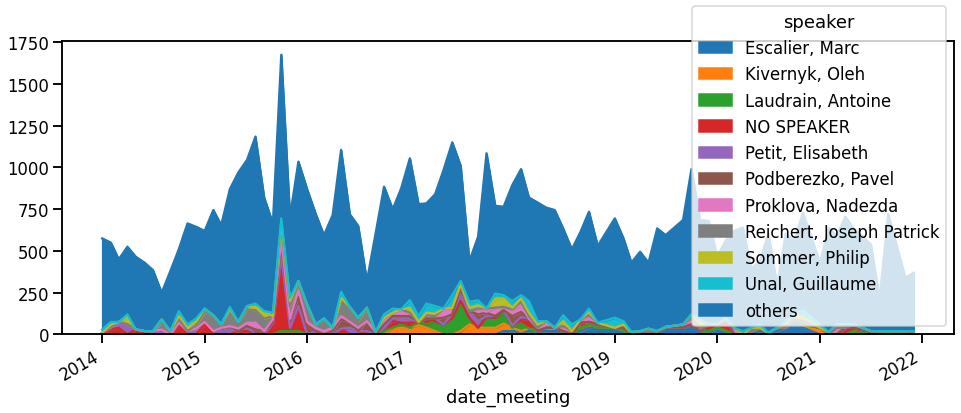

In [20]:
mask_introduction = df.apply(lambda x: 'introduction' in x['title_contribution'].lower(), axis=1)
df_no_introduction = df[np.logical_not(mask_introduction)]
df_grouped_by_group_no_introduction = df_no_introduction.groupby('group')
for group, group_data in df_grouped_by_group_no_introduction:
    g = group_data.groupby('speaker')['duration'].sum().sort_values(inplace=False, ascending=False)
    top_user = g[:10].keys()
    top_user_mask = [vv in top_user for vv in group_data['speaker']]
    g = group_data[top_user_mask].groupby([pd.Grouper(freq='MS',key='date_meeting'), 'speaker'])['duration'].sum().unstack()
    g_others = group_data[np.logical_not(top_user_mask)].groupby([pd.Grouper(freq='MS',key='date_meeting'), 'speaker'])['duration'].sum().unstack().sum(axis=1)
    g['others'] = g_others
    g.plot(kind='area', stacked=True, figsize=(16, 6))

Text(0.5, 1.0, 'duration')

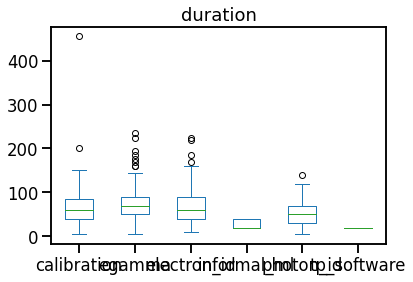

In [21]:
ax = df.groupby(['date_meeting', 'my_title'])["duration"].sum().unstack('my_title').plot(kind='box')
ax.set_title('duration')

1.4191780821917808


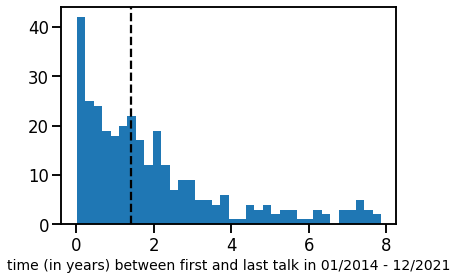

In [112]:
d = df.groupby('speaker')['date_meeting'].agg(['min', 'max'])
d = d['max'] - d['min']
d = d / pd.Timedelta(365, 'days')
d = d[d>0]
fig, ax = plt.subplots()
d.hist(bins=36, ax=ax)
ax.grid(False)
ax.axvline(d.median(), color='k', ls='--')
ax.set_xlabel('time (in years) between first and last talk in %s' % time_range_string, fontsize=14)
print(d.median())
fig.savefig('speaker_lifespan.pdf', bbox_inches='tight')

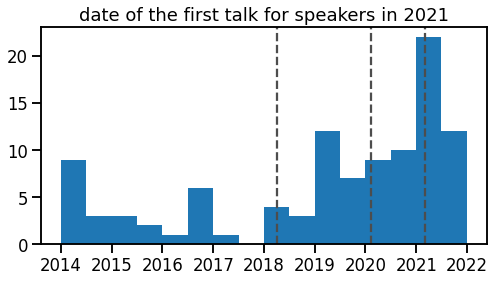

In [110]:
first_meeting = df_no_introduction.groupby('speaker')['date_meeting'].min()


d = df_no_introduction[df_no_introduction['date_meeting'].dt.year == 2021]
h = first_meeting[d['speaker'].unique()]
fig, ax = plt.subplots(figsize=(8, 4))
h.hist(ax=ax, grid=False, bins=pd.date_range(datetime.datetime(h.min().year, 1, 1), datetime.datetime(h.max().year, 12, 31), 17))
for q in h.quantile([0.25, 0.5, 0.75]):
    ax.axvline(q, color='0.3', ls='--')
ax.set_title('date of the first talk for speakers in 2021')
fig.savefig('first_talk.pdf', bbox_inches='tight')

2014 0.0
2015 0.0
2016 0.17987152034261242
2017 0.3277777777777778
2018 0.3501144164759725
2019 0.25722543352601157
2020 0.3238993710691824
2021 0.33548387096774196


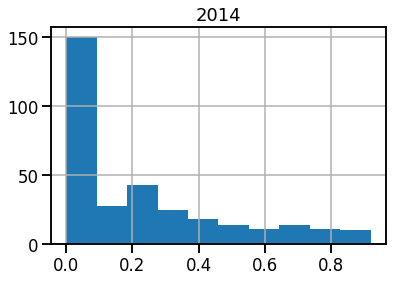

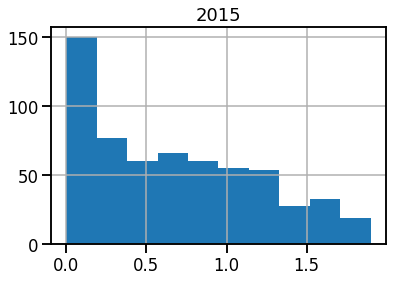

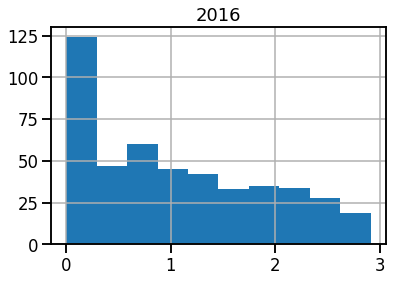

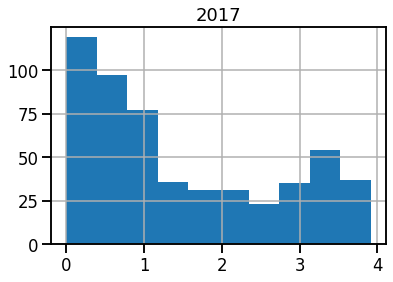

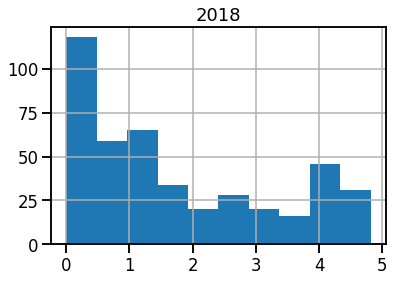

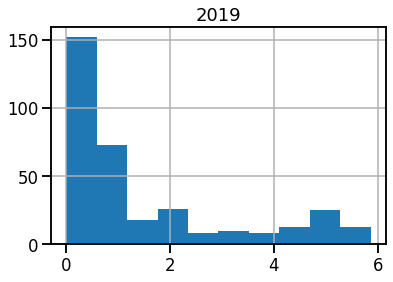

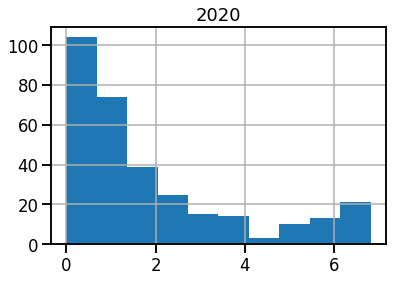

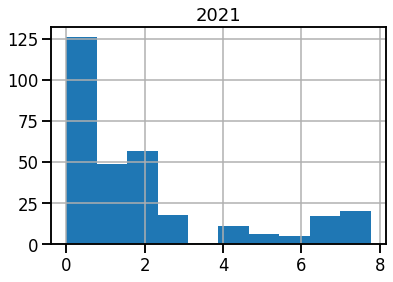

In [24]:
for year, d in df_no_introduction.groupby(df_no_introduction['date_meeting'].dt.year):
    fig, ax = plt.subplots()
    d = d.join(first_meeting.to_frame(), on='speaker', rsuffix='_first')
    d['delta'] = d['date_meeting'] - d['date_meeting_first']
    #print(year, d['delta'].mean())
    print(year, (d['delta'] > pd.Timedelta(2*365, 'days')).sum() / len(d))
    (d['delta'] / pd.Timedelta(365, 'days')).hist(ax=ax)
    ax.set_title(year)

In [46]:
df_jira = pd.read_csv('CERN Central Jira 2022-02-04T12_40_05+0100.csv', parse_dates=['Created', 'Updated'])
print(df_jira['Status'].value_counts())
df_jira['Created'].min()

Closed    82
Open      18
Name: Status, dtype: int64


Timestamp('2016-10-08 00:27:00')

In [51]:
df_jira.query('Status=="Open"').groupby('Labels').size()

Labels
EGCalibration    2
EGIsolation      1
Electron         1
ElectronID       6
HLLHC            1
Heavy-Ions       1
PhotonID         6
dtype: int64

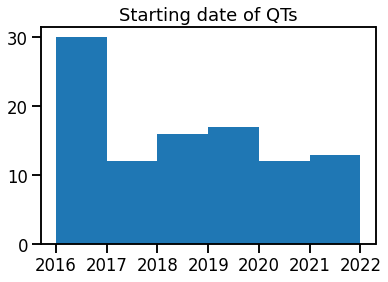

In [65]:
fig, ax = plt.subplots()
df_jira['Created'].hist(grid=False, bins=pd.date_range(datetime.datetime(df_jira['Created'].min().year, 1, 1), datetime.datetime(df_jira['Created'].max().year, 12, 31), 7))
ax.set_title("Starting date of QTs")
fig.savefig('qt_starting.pdf', bbox_inches='tight')

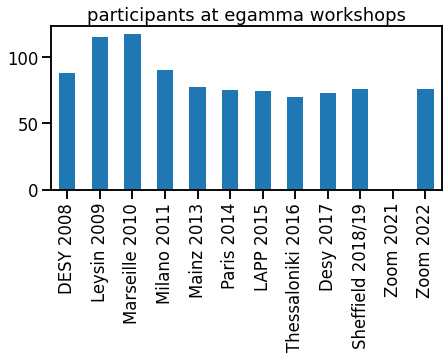

In [107]:
from io import StringIO

d = pd.read_csv(StringIO("""
DESY         & 2008    & 88  \\
Leysin       & 2009    & 115 \\
Marseille    & 2010    & 117 \\
Milano       & 2011    & 90  \\
Mainz        & 2013    & 77  \\
Paris        & 2014    & 75  \\
LAPP         & 2015    & 74  \\
Thessaloniki & 2016    & 70  \\
Desy         & 2017    & 73  \\
Sheffield    & 2018/19 & 76  \\
Zoom         & 2021    &
Zoom         & 2022    & 76  \\
""".replace('\\', '')), sep='&', header=None)

d['workshop'] = d.apply(lambda x: x[0].strip() + " " + x[1].strip(), axis=1)
d = d.drop([0, 1], axis=1)
d = d.rename(columns={2: 'participants'})
fig, ax = plt.subplots(figsize=(7, 3))
d.set_index('workshop')['participants'].plot.bar(ax =ax)
ax.set_title('participants at egamma workshops')
ax.set_xlabel('')
fig.savefig('workshops.pdf', bbox_inches='tight')